# Convolutional Autoencoder - Post Process

## 1. initialize

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import time as tm
import os
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras.models import load_model

%matplotlib inline

In [2]:
np.random.seed(1) # to make the results reproducible

In [3]:
# TensorFlow 2.1, Keras - workaround:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [4]:
# Detect the number of train data mini batches. Shuffle them and divide into a train/test parts.

fname_pattern = "./bengaliai-cv19/train_batch_{:03d}.pickle"
train_test_split = 0.7

mbatch_no = 0
while os.path.exists(fname_pattern.format(mbatch_no)):
    mbatch_no = mbatch_no + 1
print("{} train data file(s) found.".format(mbatch_no))

mbatch_train_no = round(mbatch_no * 0.7)
mbatch_test_no = mbatch_no - mbatch_train_no
mbatch_idx = np.random.permutation(mbatch_no)
mbatch_train_idx = mbatch_idx[:mbatch_train_no]
mbatch_test_idx = mbatch_idx[mbatch_train_no:]

197 train data file(s) found.


## 2. Helper functions

In [5]:
def load_batch(mbatch_no):
    fname = fname_pattern.format(mbatch_no)
    with open(fname, "rb") as f:
        batch = pickle.load(f)
        return batch

In [6]:
def prepare_image(img):
    pil_img = PIL.Image.fromarray(img)
    new_pil_img = pil_img.resize((256, 256), PIL.Image.ANTIALIAS)
    return np.array(new_pil_img)

In [7]:
def prepare_batch(batch):
    new_X = np.zeros((batch['X'].shape[0], 256, 256), dtype=float)
    for i in range(new_X.shape[0]):
        new_X[i, :, :] = prepare_image(batch['X'][i, :, :])
    batch['X'] = new_X

## 3. Load model

In [8]:
model = load_model('output/model.h5')

## 4. Create submodel

In [9]:
X = tf.keras.layers.Input(shape=[256, 256, 1], dtype=tf.float32)

Z1 = tf.keras.layers.Conv2D(filters=8, kernel_size=[5,5], strides=[1,1], padding="same", dilation_rate=[1,1])(X)
B1 = tf.keras.layers.BatchNormalization(axis=3)(Z1)
A1 = tf.keras.layers.LeakyReLU(alpha=0.1)(B1)
P1 = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")(A1)

Z2 = tf.keras.layers.Conv2D(filters=16, kernel_size=[5,5], strides=[1,1], padding="same", dilation_rate=[1,1])(P1)
B2 = tf.keras.layers.BatchNormalization(axis=3)(Z2)
A2 = tf.keras.layers.LeakyReLU(alpha=0.1)(B2)
P2 = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")(A2)

Z3 = tf.keras.layers.Conv2D(filters=32, kernel_size=[5,5], strides=[1,1], padding="same", dilation_rate=[1,1])(P2)
B3 = tf.keras.layers.BatchNormalization(axis=3)(Z3)
A3 = tf.keras.layers.LeakyReLU(alpha=0.1)(B3)
P3 = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")(A3)

Z4 = tf.keras.layers.Conv2D(filters=32, kernel_size=[5,5], strides=[1,1], padding="same", dilation_rate=[1,1])(P3)
B4 = tf.keras.layers.BatchNormalization(axis=3)(Z4)
A4 = tf.keras.layers.LeakyReLU(alpha=0.1)(B4)
P4 = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")(A4)

Z5 = tf.keras.layers.Conv2D(filters=32, kernel_size=[5,5], strides=[1,1], padding="same", dilation_rate=[1,1])(P4)
B5 = tf.keras.layers.BatchNormalization(axis=3)(Z5)
A5 = tf.keras.layers.LeakyReLU(alpha=0.1)(B5)
P5 = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")(A5)

submodel = tf.keras.models.Model(inputs=X, outputs=P5) # Keras 2.2.4 from TensorFlow 2.1.0
submodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, clipvalue=1.0), loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])
submodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 8)       208       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 8)       32        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      3216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 16)      64    

In [10]:
for i, layer in enumerate(submodel.layers[1:]): # except input layer
    layer_weights = model.layers[i].get_weights()
    submodel.layers[i].set_weights(layer_weights)

In [11]:
submodel.save("output/submodel.h5")

In [12]:
def predict(img):
    inp_img = img.reshape(1, img.shape[0], img.shape[1], 1)
    pred_img = submodel.predict(inp_img)
    return pred_img

## 5. Verify

In [13]:
test_batch = load_batch(mbatch_test_idx[0])
prepare_batch(test_batch)

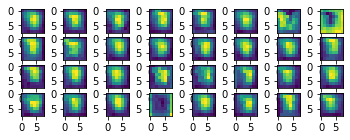

In [14]:
y_pred = predict(test_batch['X'][0])
for i in range(y_pred.shape[3]):
    plt.subplot(8, 8, i + 1)
    plt.imshow(y_pred[0, :, :, i])

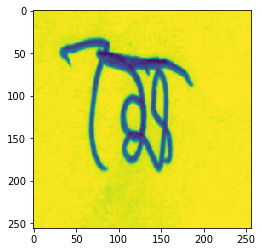

In [15]:
plt.imshow(test_batch['X'][0])